In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from snmfem.datasets.generate_weights import generate_weights
from snmfem.datasets.generate_EDXS_phases import generate_random_phases, DEFAULT_PARAMS, unique_elts
from snmfem.models import EDXS
import matplotlib.pyplot as plt
import math as m
import numpy as np
import json
from snmfem.datasets import generate_dataset_from_json
from pathlib import Path
from snmfem.conf import SCRIPT_CONFIG_PATH

# Generate weights
## Inputs + weights generation

In [2]:
n_phases = 4
seed = 2
weights_dict = {
    "weight_type" : "sphere",
    "shape_2D" : [80,80],
}

weights = generate_weights(**weights_dict,n_phases=n_phases,seed=seed)


## Plot of the weights

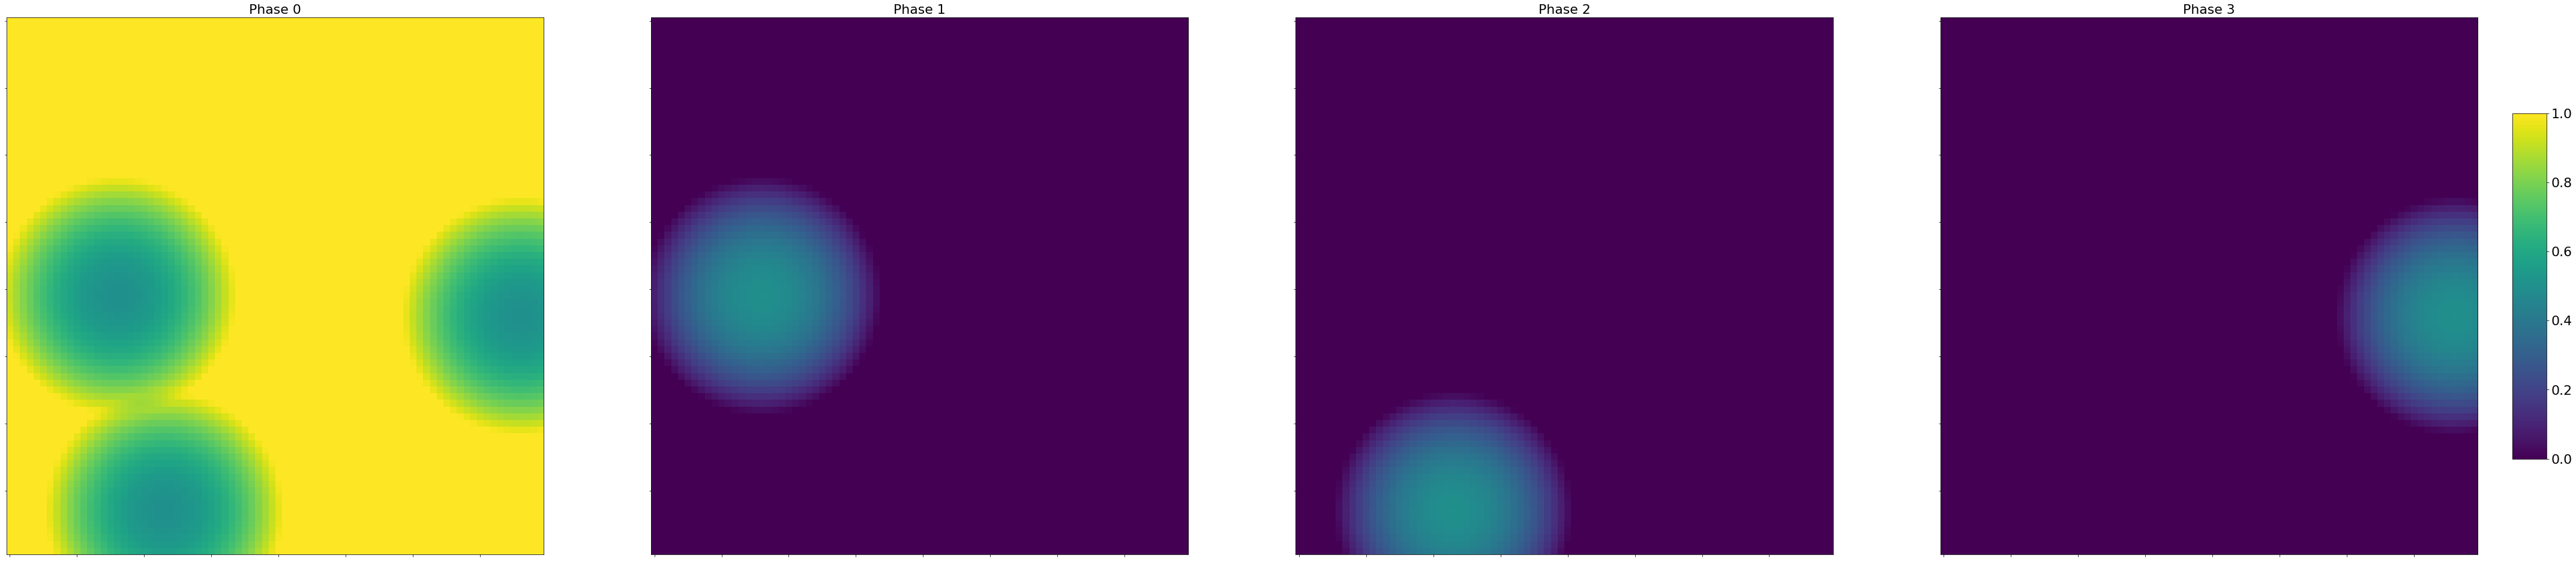

In [3]:
size = weights_dict["shape_2D"][0]
fig,axs = plt.subplots(1,n_phases,figsize = (size,size*n_phases))
for j in range(axs.shape[0]) :
        im = axs[j].imshow(weights[:,:,j],vmin = 0, vmax = 1.0)
        axs[j].tick_params(axis = "both",labelbottom = False,labelleft = False) 
        axs[j].set_title("Phase {}".format(j),fontsize = 22)

fig.subplots_adjust(right=0.84)
# put colorbar at desire position
cbar_ax = fig.add_axes([0.85, 0.49, 0.01, 0.025])
fig.colorbar(im,cax=cbar_ax)
cbar_ax.tick_params(labelsize=22)


# Generate phases
## Phases generation

In [5]:
phases, phases_dicts = generate_random_phases(n_phases,seed)

## Plot of the phases

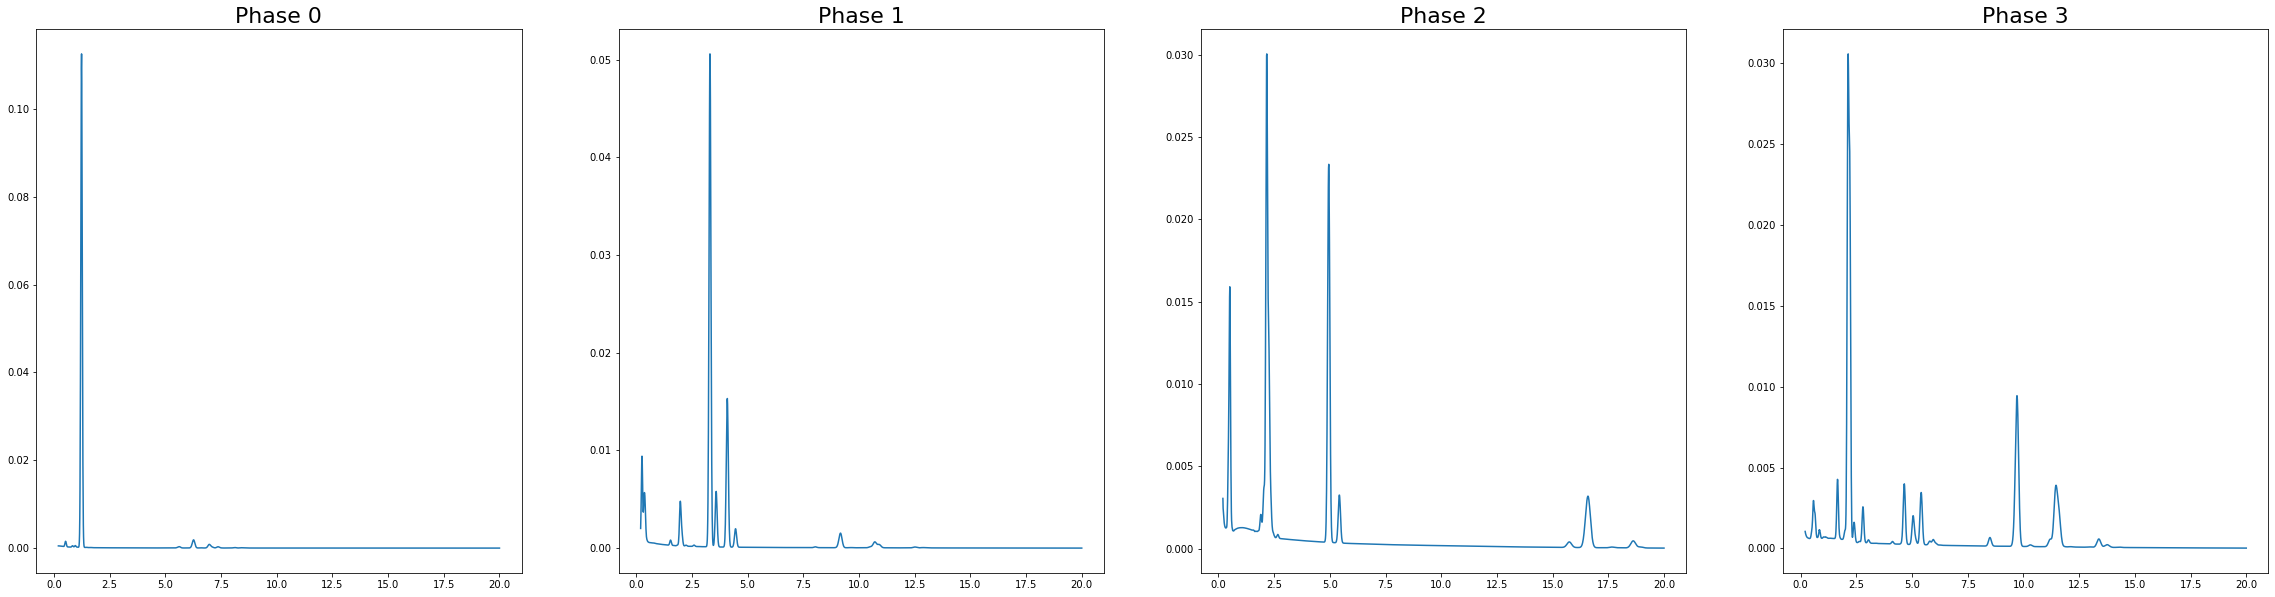

In [6]:
size = 10
fig,axs = plt.subplots(1,n_phases,figsize = (size*n_phases,size))

x = np.linspace(
    DEFAULT_PARAMS["e_offset"],
    DEFAULT_PARAMS["e_offset"]+DEFAULT_PARAMS["e_scale"]*DEFAULT_PARAMS["e_size"],
    num=DEFAULT_PARAMS["e_size"])

for j in range(axs.shape[0]) :
    axs[j].plot(x,phases[j])
    axs[j].set_title("Phase {}".format(j),fontsize = 22)


# Generate Data
## Input + json generation

In [7]:
np.random.seed(seed)
data_dict = {
    "N" : 100,
    "densities" : list(3*np.random.rand(n_phases)),
    "data_folder" : "aspim039_random_phases",
    "seeds_range" : 10
}

json_filename = SCRIPT_CONFIG_PATH / Path("dataset_random_phases.json")

## Save the json and generate the data

In [8]:
g_params = {
    "brstlg" : True,
    "elements_list" : unique_elts(phases_dicts)
}

json_dict = {}
json_dict["model"] = "EDXS"
json_dict.update(data_dict)
json_dict["weights_parameters"] = weights_dict
json_dict["model_parameters"] = DEFAULT_PARAMS
json_dict["g_parameters"] = g_params
json_dict["phases_parameters"] = phases_dicts

with open(json_filename,"w") as f : 
    json.dump(json_dict,f,indent=4)

generate_dataset_from_json(json_filename)


100%|██████████| 10/10 [00:30<00:00,  3.04s/it]
